# Summary Statistics of Entire Dataset

In [2]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sqlalchemy as sa
from sqlalchemy import text

In [3]:
# find the current working directory
import os
import IPython

notebook_path = IPython.get_ipython().getoutput('pwd')[0]

data_dir = os.path.join(notebook_path, '..', 'data')

if not os.path.exists(data_dir):
    print(f'Creating directory: {data_dir}')
    os.makedirs(data_dir)

In [4]:
sns.set_style("ticks")

DEFAULT_COLOR = sns.color_palette("husl", 9)[6]

In [5]:
from datetime import datetime

date = datetime.now().strftime("%Y-%m-%d")

# create dir for figures
figures_dir = os.path.join(notebook_path, "..", "figures", "analysis_2", date)

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [6]:
def add_bar_labels(ax, fmt="{:.0f}", ignore_zero=True):
    for bar in ax.patches:

        if bar.get_height() == 0 and ignore_zero:
            continue

        # Use ax.text() to add text over the bars
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                fmt.format(bar.get_height()),
                ha='center', va='bottom')


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

In [7]:
# read db connection from .env file
from helpers.settings import get_settings

settings = get_settings()

Loading settings ...


In [8]:
engine = sa.create_engine(settings.postgresql_dsn.__str__())

In [9]:
with engine.connect() as conn:
    res = conn.execute(
        text(
            """
    SELECT COUNT(individual_id) AS num_patients
    FROM individual
    """
        )
    ).scalars().all()
    print(f"Number of patients TOTAL: {res[0]}")

    res = conn.execute(
        text(
            """
            SELECT COUNT(variant_id) AS num_variants
            FROM variant_view_mv v
            WHERE provenance @> jsonb_build_array(jsonb_build_object('dataset_id', 2))
            """
        )
    ).scalars().all()

    print(f"Number of variants: {res[0]}")

    res = conn.execute(
        text(
            """
            SELECT COUNT(DISTINCT individual_id) AS num_cpvt_patients
            FROM cpvt_patients_v
            """
        )
    )

    print(f"Number of CPVT patients: {res.scalar()}")

    res = conn.execute(
        text(
            """
            SELECT COUNT(publication_id)
            FROM publication
            """
        )).scalars().all()

    print(f"Number of publications: {res[0]}")

Number of patients TOTAL: 1347
Number of variants: 392
Number of CPVT patients: 968
Number of publications: 227


In [10]:
# get number of male / female patients
individuals_mv = pd.read_sql(
    """
    SELECT i.individual_id, s.value AS sex
    FROM individual i
    JOIN individual_sex s
    ON i.individual_sex_id = s.individual_sex_id
    JOIN individual_condition ic
    ON i.individual_id = ic.individual_id
    WHERE ic.has_condition = true
    AND ic.condition_id IN (
        SELECT condition_id
        FROM condition
        WHERE condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
        AND has_condition = true
    )
    ORDER BY i.individual_id
    """
    , engine)
individuals_mv.head()

,individual_id,sex
0,2,female
1,3,male
2,4,female
3,5,male
4,6,female


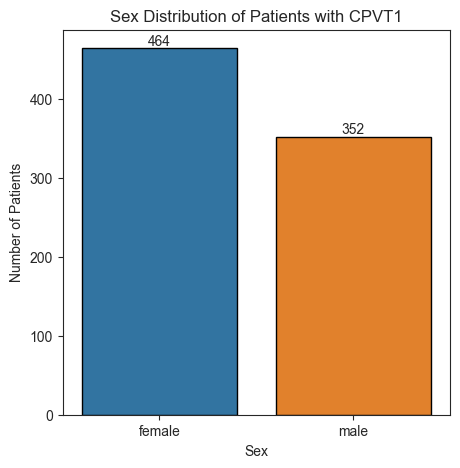

In [11]:
plt.figure(figsize=(5, 5))

ax = sns.countplot(data=individuals_mv,
                   x="sex",
                   hue="sex",
                   legend=False,
                   edgecolor="black",
                   )

plt.xlabel("Sex")
plt.ylabel("Number of Patients")
plt.title("Sex Distribution of Patients with CPVT1")

add_bar_labels(ax)

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'sex_distribution_cpvt1.' + fmt), dpi=300)

plt.show()

In [12]:
# get number male, female, NAN
sex_agg = pd.read_sql("""
    SELECT s.value AS sex,
    COUNT(i.individual_id) AS num_patients
    FROM individual i
    JOIN individual_sex s
    ON i.individual_sex_id = s.individual_sex_id
    JOIN individual_condition ic
    ON i.individual_id = ic.individual_id
    WHERE ic.has_condition = true
    AND ic.condition_id IN (
        SELECT condition_id
        FROM condition
        WHERE condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
        AND has_condition = true
    )
    GROUP BY s.value
""", engine)
sex_agg["percentage"] = sex_agg['num_patients'] / sex_agg['num_patients'].sum() * 100
sex_agg

,sex,num_patients,percentage
0,female,464,56.862745
1,male,352,43.137255


In [13]:
# get patient inheritance

In [14]:
# plot primary diagnosis for each individual
prim_diagnosis = pd.read_sql(
    """
    SELECT c.condition, COUNT(ic.individual_id) AS num_patients
    FROM individual_condition ic
    JOIN condition c
    ON c.condition_id = ic.condition_id
    WHERE primary_diagnosis = true
    AND condition <> 'Substance use disorder'
    GROUP BY c.condition
    ORDER BY num_patients DESC
    """
    , engine)
prim_diagnosis.head()

,condition,num_patients
0,Catecholaminergic polymorphic ventricular tach...,968
1,Catecholaminergic polymorphic ventricular tach...,132
2,Long QT syndrome,45
3,Left ventricular non-compaction,18
4,Arrhythmogenic right ventricular cardiomyopathy,18


In [15]:
prim_diagnosis

,condition,num_patients
0,Catecholaminergic polymorphic ventricular tach...,968
1,Catecholaminergic polymorphic ventricular tach...,132
2,Long QT syndrome,45
3,Left ventricular non-compaction,18
4,Arrhythmogenic right ventricular cardiomyopathy,18
5,Short-coupled variant of torsade de pointes,15
6,Sudden infant death syndrome,13
7,Hyperglycemia,7
8,Other,7
9,Hypoplastic left heart syndrome,5


In [16]:

pd.read_sql("""
SELECT c.condition, cs.synonym
FROM condition c
LEFT JOIN condition_synonym cs
ON c.condition_id = cs.condition_id
WHERE c.condition = 'Short-coupled variant of torsade de pointes'
""", engine)

,condition,synonym
0,Short-coupled variant of torsade de pointes,scTdP


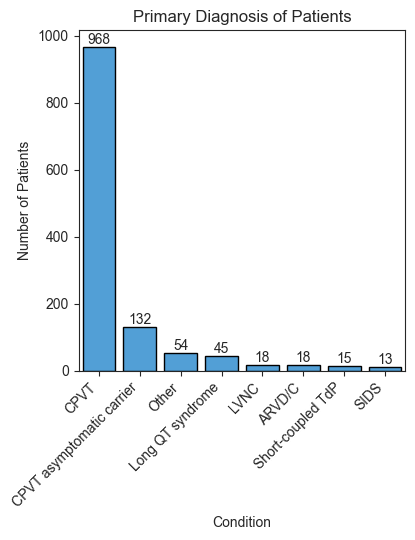

In [17]:
# group everything with less than 10 patients into "Other"
prim_diagnosis2 = prim_diagnosis.copy()
prim_diagnosis2.loc[
    prim_diagnosis["num_patients"] < 10, "condition"] = "Other"
prim_diagnosis2 = prim_diagnosis2.groupby("condition").sum().reset_index()
prim_diagnosis2.sort_values("num_patients", ascending=False, inplace=True)

shorter_names_map = {
    "Catecholaminergic polymorphic ventricular tachycardia 1": "CPVT",
    "Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier": "CPVT asymptomatic carrier",
    "Arrhythmogenic right ventricular cardiomyopathy": "ARVD/C",
    "Short-coupled variant of torsade de pointes": "Short-coupled TdP",
    "Left ventricular non-compaction": "LVNC",
    "Sudden infant death syndrome": "SIDS",
    "Hypoplastic left heart syndrome": "HLHS",
}

# replace with shorter names
prim_diagnosis2["condition"] = prim_diagnosis2["condition"].replace(
    shorter_names_map)

plt.figure(figsize=(4.25, 5.5))
ax = sns.barplot(prim_diagnosis2, x="condition", y="num_patients",
                 color=DEFAULT_COLOR, edgecolor="black", )

add_bar_labels(ax)

plt.xticks(rotation=45, ha="right")

plt.xlabel("Condition")
plt.ylabel("Number of Patients")
plt.title("Primary Diagnosis of Patients")

plt.tight_layout()

save_current_plot("primary_diagnosis")

plt.show()

In [18]:
conditions_to_graph = {
    "Exercise/stress induced polymorphic ventricular tachycardia": "Exercise-induced polymorphic VT",
    "Syncope exercise/stress induced": "Exercise-induced syncope",
    "Exercise/stress induced sudden cardiac arrest": "Exercise-induced Sudden Cardiac Arrest",
    "Baseline/resting electrocardiogram abnormality": "Abnormal ECG at rest",
    "Heart Structure Abnormality": "Heart Structure Abnormality",
}

individual_condition_graph = pd.read_sql(
    f"""
    SELECT
    c.condition,
    ic.has_condition,
    COUNT(ic.individual_id) AS num_patients
    FROM individual_condition ic
    JOIN condition c
    ON c.condition_id = ic.condition_id
    WHERE c.condition IN {tuple(conditions_to_graph)}
    AND ic.has_condition IS NOT NULL
    AND ic.individual_id IN (
        SELECT individual_id
        FROM individual_condition ic2
        JOIN condition c2
        ON c2.condition_id = ic2.condition_id
        WHERE c2.condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
        AND ic2.has_condition = true
    )   
    GROUP BY c.condition, ic.has_condition
    ORDER BY c.condition, ic.has_condition
    """, engine)
individual_condition_graph

,condition,has_condition,num_patients
0,Baseline/resting electrocardiogram abnormality,False,388
1,Baseline/resting electrocardiogram abnormality,True,77
2,Exercise/stress induced polymorphic ventricula...,False,7
3,Exercise/stress induced polymorphic ventricula...,True,316
4,Exercise/stress induced sudden cardiac arrest,False,16
5,Exercise/stress induced sudden cardiac arrest,True,97
6,Heart Structure Abnormality,False,449
7,Heart Structure Abnormality,True,45
8,Syncope exercise/stress induced,False,9
9,Syncope exercise/stress induced,True,262


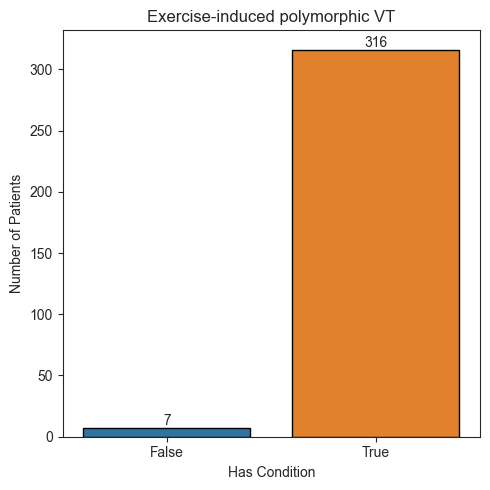

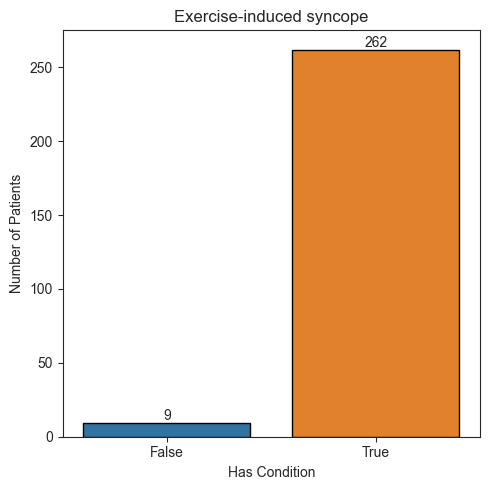

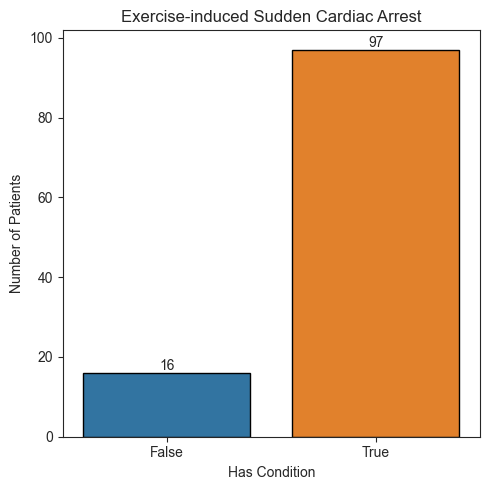

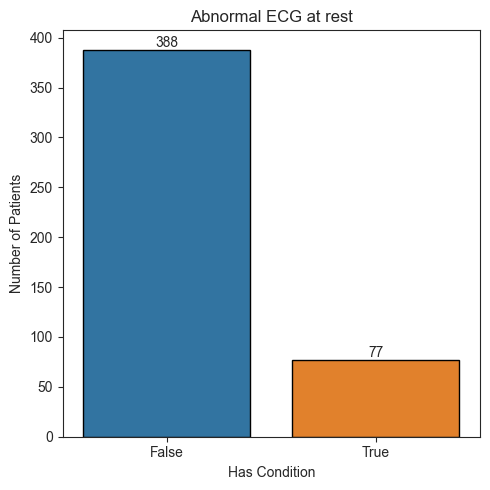

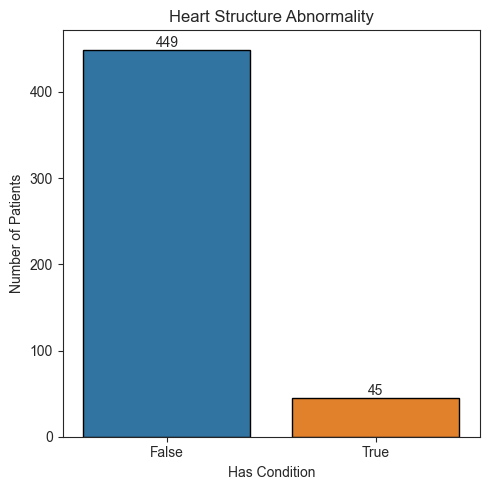

In [19]:
for condition, title in conditions_to_graph.items():
    condition_data = individual_condition_graph[
        individual_condition_graph["condition"] == condition
        ]

    plt.figure(figsize=(5, 5))
    ax = sns.barplot(
        data=condition_data,
        x="has_condition",
        y="num_patients",
        hue="has_condition",
        legend=False,
        edgecolor="black",
    )

    add_bar_labels(ax)

    plt.title(title)
    plt.xlabel("Has Condition")
    plt.ylabel("Number of Patients")

    plt.tight_layout()

    save_current_plot(title)

    plt.show()



In [20]:
# inheritance pattern of CPVT1
inheritance = pd.read_sql("""
SELECT vi.variant_inheritance, COUNT(i.individual_id) AS num_patients
FROM individual i 
JOIN individual_variant iv
ON i.individual_id = iv.individual_id
JOIN variant_inheritance vi
ON iv.variant_inheritance_id = vi.variant_inheritance_id
WHERE i.individual_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
)
GROUP BY vi.variant_inheritance 
ORDER BY num_patients DESC
""", engine)
inheritance

,variant_inheritance,num_patients
0,inherited,186
1,spontaneous,88


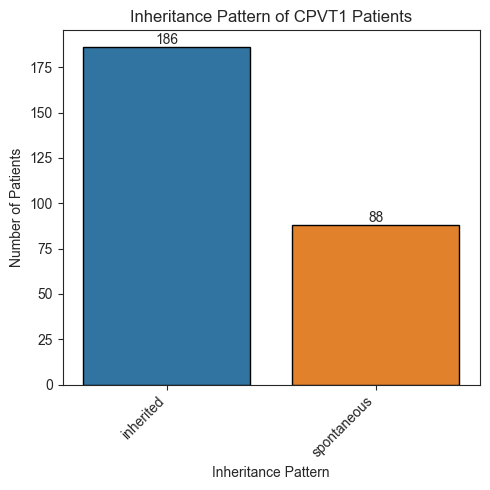

In [21]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(data=inheritance,
                 x="variant_inheritance",
                 y="num_patients",
                 hue="variant_inheritance",
                 legend=False,
                 edgecolor="black",
                 )
plt.xticks(rotation=45, ha="right")
plt.xlabel("Inheritance Pattern")
plt.ylabel("Number of Patients")
plt.title("Inheritance Pattern of CPVT1 Patients")

add_bar_labels(ax)

plt.tight_layout()
save_current_plot("inheritance_pattern_cpvt1")

plt.show()


In [22]:
family_history_scd = pd.read_sql("""
SELECT individual_id,
bool_or(has_family_history) AS has_family_history
FROM (
SELECT fhr.individual_id,
        CASE WHEN num_family_members >= 1 THEN TRUE
        WHEN has_condition = TRUE THEN TRUE
        WHEN has_condition = FALSE THEN FALSE
        WHEN num_family_members = 0 THEN FALSE
        ELSE
            NULL
        END AS has_family_history
FROM family_history_record fhr
JOIN condition c
ON fhr.condition_id = c.condition_id
LEFT JOIN family_member_history fmh
ON fhr.family_history_record_id = fmh.family_history_record_id
WHERE c.condition = 'Sudden cardiac death'
AND fhr.individual_id IN (
    SELECT individual_id
    FROM individual_condition ic
    JOIN condition c2
    ON ic.condition_id = c2.condition_id
    WHERE c2.condition = 'Catecholaminergic polymorphic ventricular tachycardia 1'
    AND ic.has_condition = true
)
) AS subquery
WHERE has_family_history IS NOT NULL
GROUP BY individual_id
""", engine)
family_history_scd.head()

,individual_id,has_family_history
0,1,True
1,4,False
2,10,True
3,11,True
4,13,False


In [23]:
family_history_scd["has_family_history"].value_counts(dropna=False)

has_family_history
True     349
False    144
Name: count, dtype: int64

In [24]:
family_history_scd.shape

(493, 2)

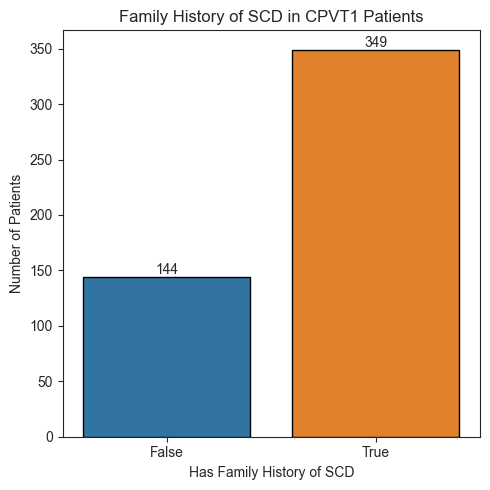

In [25]:
plt.figure(figsize=(5, 5))

ax = sns.countplot(data=family_history_scd,
                   x="has_family_history",
                   hue="has_family_history",
                   legend=False,
                   edgecolor="black",
                   )

plt.xlabel("Has Family History of SCD")
plt.ylabel("Number of Patients")
plt.title("Family History of SCD in CPVT1 Patients")

add_bar_labels(ax)

plt.tight_layout()
for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, 'family_history_scd.' + fmt), dpi=300)

plt.show()

# Treatments

In [26]:
# treatments for patients using Beta Blockers
beta_blockers = pd.read_sql("""
SELECT t.treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
WHERE tr.patient_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
) AND
tr.treatment_taken = TRUE AND 
tr.patient_id IN (
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
GROUP BY t.treatment_name 
ORDER BY num_patients DESC
""", engine)
beta_blockers

,treatment_name,num_patients
0,Beta blocker,434
1,Flecainide,117
2,Implantable cardioverter-defibrillator,116
3,Verapamil,28
4,Left cardiac sympathetic denervation,22
5,Catheter ablation,10
6,Enalapril,2


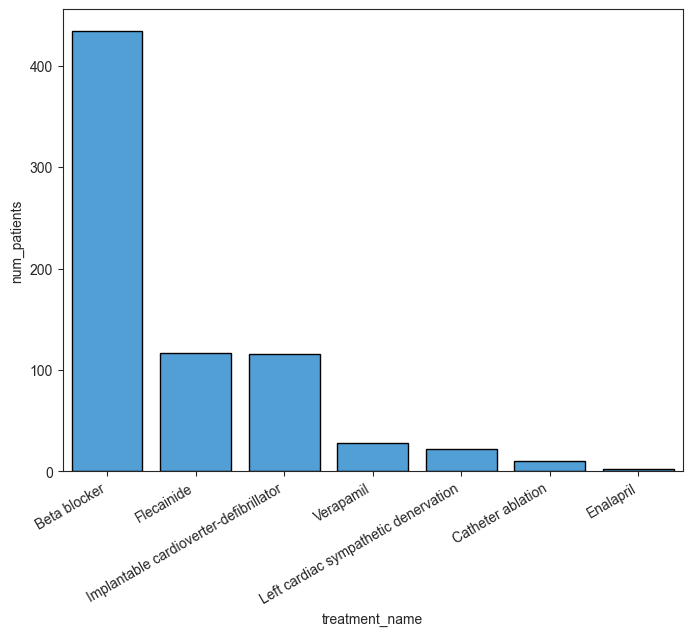

In [27]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=beta_blockers, x="treatment_name", y="num_patients",
                 color=DEFAULT_COLOR, edgecolor="black", )

plt.xticks(rotation=30, ha="right")

plt.show()

In [28]:
# drop beta blocker
extra_treatments = beta_blockers[
    beta_blockers["treatment_name"] != "Beta blocker"].copy()

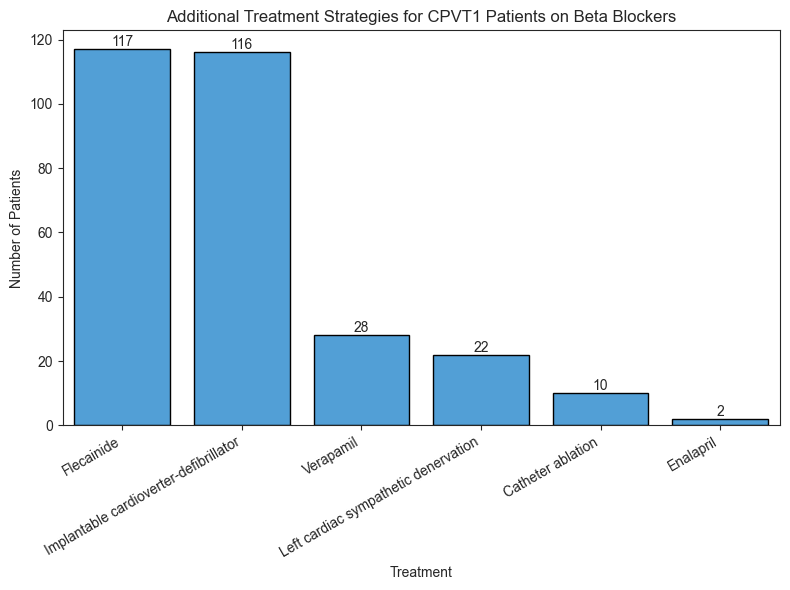

In [29]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=extra_treatments, x="treatment_name", y="num_patients",
                 color=DEFAULT_COLOR, edgecolor="black", )

plt.xticks(rotation=30, ha="right")

plt.xlabel("Treatment")
plt.ylabel("Number of Patients")
plt.title("Additional Treatment Strategies for CPVT1 Patients on Beta Blockers")

add_bar_labels(ax)

plt.tight_layout()

save_current_plot("treatment_strategies_cpvt1")

plt.show()


In [56]:
# effective percentage per treatment
effective_treatments = pd.read_sql("""
SELECT t.treatment_name, tr.effective, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
WHERE tr.patient_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
) AND
tr.treatment_taken = TRUE
AND tr.effective IS NOT NULL
GROUP BY t.treatment_name, tr.effective
ORDER BY t.treatment_name, tr.effective
""", engine)
effective_treatments

,treatment_name,effective,num_patients
0,Beta blocker,False,114
1,Beta blocker,True,127
2,Catheter ablation,False,3
3,Catheter ablation,True,9
4,Enalapril,True,2
5,Flecainide,False,29
6,Flecainide,True,75
7,Implantable cardioverter-defibrillator,False,32
8,Implantable cardioverter-defibrillator,True,75
9,Left cardiac sympathetic denervation,False,3


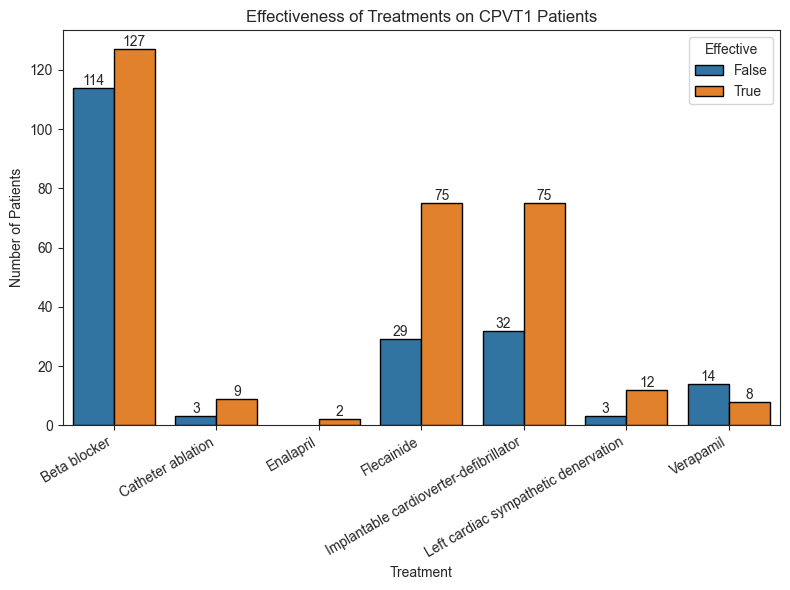

In [57]:
# plot the effective treatments
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=effective_treatments, x="treatment_name", y="num_patients",
                 hue="effective", edgecolor="black")

plt.xticks(rotation=30, ha="right")
plt.xlabel("Treatment")
plt.ylabel("Number of Patients")

plt.title("Effectiveness of Treatments on CPVT1 Patients")

plt.legend(title="Effective")

add_bar_labels(ax)

plt.tight_layout()

save_current_plot("treatment_effectiveness")

plt.show()

In [31]:
NUM_TOP_VARIANTS = 5

# mutation specific strageties for most common mutations
mutation_strategies = pd.read_sql(f"""
SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WITH TOP 5 VARIANTS BY NUMBER OF INDIVIDUALS
    SELECT iv.individual_id
    FROM individual_variant iv
    JOIN variant v 
    ON iv.variant_id = v.variant_id
    WHERE v.variant_id IN (
        SELECT v2.variant_id 
        FROM variant_num_individuals_v v2 
        ORDER BY v2.num_individuals DESC 
        LIMIT {NUM_TOP_VARIANTS}
    )
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.treatment_taken = TRUE
GROUP BY sv.p_posedit_str, treatment_name
ORDER BY sv.p_posedit_str, treatment_name
""", engine)
# drop the row "Beta blocker" as it is redundant
# mutation_strategies = mutation_strategies[
#     mutation_strategies["treatment_name"] != "Beta blocker"]
mutation_strategies["p_posedit_str"] = mutation_strategies[
    "p_posedit_str"].apply(
    lambda x: re.sub(r"[\(\)]", "", x))
mutation_strategies.head()

,p_posedit_str,treatment_name,num_patients
0,Arg420Gln,Beta blocker,24
1,Arg420Gln,Catheter ablation,4
2,Arg420Gln,Flecainide,2
3,Arg420Gln,Implantable cardioverter-defibrillator,13
4,Arg420Trp,Beta blocker,17


In [32]:
order_mutations = pd.read_sql(f"""
SELECT sv.p_posedit_str, v.hgvs_string, v.variant_id, vmv.num_individuals
FROM variant_num_individuals_v vmv
JOIN variant v
ON vmv.variant_id = v.variant_id
JOIN sequence_variant sv
ON v.sequence_variant_id = sv.sequence_variant_id
ORDER BY vmv.num_individuals DESC
LIMIT {NUM_TOP_VARIANTS}
""", engine)
order_mutations["p_posedit_str"] = order_mutations["p_posedit_str"].apply(
    lambda x: re.sub(r"[\(\)]", "", x))
order_mutations

,p_posedit_str,hgvs_string,variant_id,num_individuals
0,Gly357Ser,NM_001035.3:c.1069G>A,1372,183
1,Arg420Gln,NM_001035.3:c.1259G>A,394,55
2,Arg420Trp,NM_001035.3:c.1258C>T,393,42
3,Ser2246Leu,NM_001035.3:c.6737C>T,1,25
4,Gly2337Val,NP_001026.2:p.Gly2337Val,8970,23


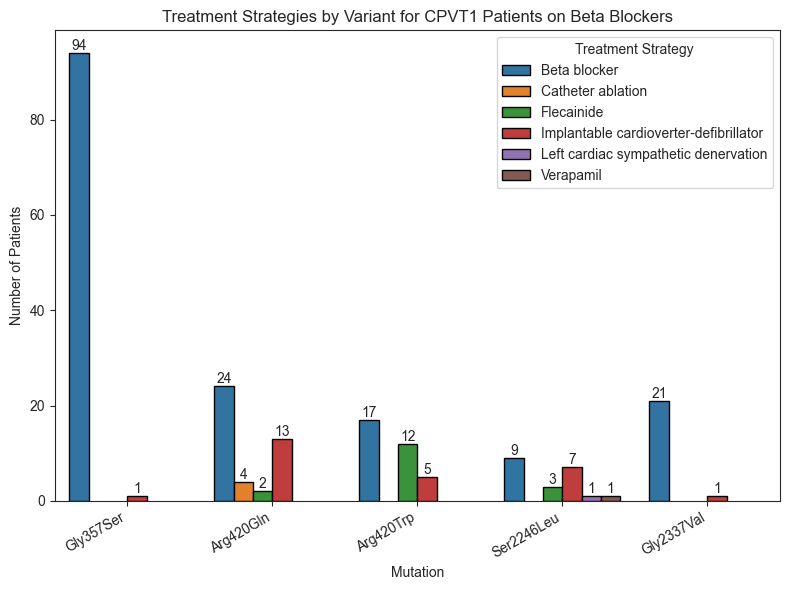

In [33]:
# grouped bar chart
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=mutation_strategies, x="p_posedit_str", y="num_patients",
                 hue="treatment_name", edgecolor="black",
                 order=order_mutations["p_posedit_str"])

add_bar_labels(ax)

plt.xticks(rotation=30, ha="right")
plt.xlabel("Mutation")
plt.ylabel("Number of Patients")
legend = plt.legend(title="Treatment Strategy", loc="upper right")
plt.title("Treatment Strategies by Variant for CPVT1 Patients on Beta Blockers")

plt.tight_layout()

plt.show()

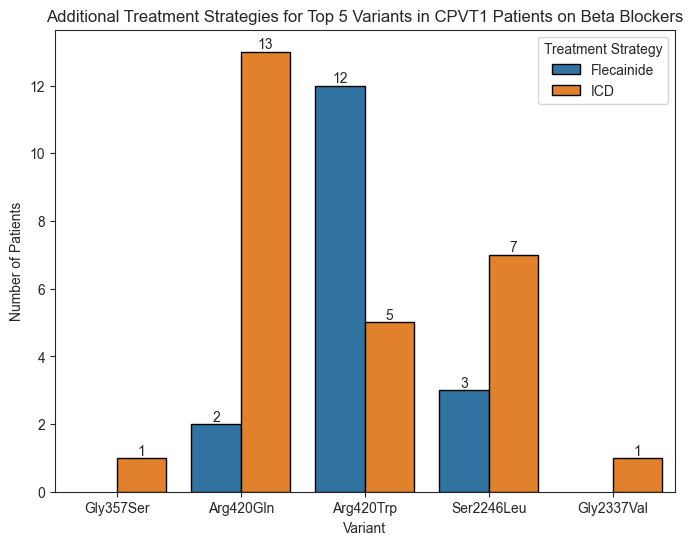

In [34]:
# grouped bar chart
plt.figure(figsize=(8, 6))

# filter to only ICD and Flecanide since they are the most common
treatment_groups = mutation_strategies[
    mutation_strategies["treatment_name"].isin(
        ["Implantable cardioverter-defibrillator", "Flecainide", ])
].copy()
treatment_groups["treatment_name"] = treatment_groups["treatment_name"].apply(
    lambda x: "ICD" if x == "Implantable cardioverter-defibrillator" else x)

ax = sns.barplot(data=treatment_groups, x="p_posedit_str", y="num_patients",
                 hue="treatment_name", edgecolor="black",
                 order=order_mutations["p_posedit_str"])

plt.xlabel("Variant")
plt.ylabel("Number of Patients")
plt.title(
    "Additional Treatment Strategies for Top 5 Variants in CPVT1 Patients on Beta Blockers")
plt.legend(title="Treatment Strategy", loc="upper right")

add_bar_labels(ax)

save_current_plot("additional_treatment_strategies_cpvt1")

plt.show()



In [35]:
from sqlalchemy import text


def make_stmt(treatment_name):
    stmt = text(f"""
SELECT sv.p_posedit_str, treatment_name, effective, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.treatment_taken = TRUE
AND t.treatment_name = :treatment_name
AND tr.effective IS NOT NULL
AND sv.p_posedit_str IS NOT NULL
GROUP BY sv.p_posedit_str, treatment_name, effective
ORDER BY num_patients DESC
""")
    stmt = stmt.bindparams(treatment_name=treatment_name)
    return stmt


def get_num_effective_treatment(treatment_name: str, engine, *, min_total_patients: int = 5):
    """
    Retrieves a table of the number of patients that are effective and ineffective for a given treatment
    The variants must have at least min_total_patients patients in total (effective + ineffective) 
    taking the treatment and recorded as taking beta blockers and have the effectiveness recorded
    :param treatment_name: 
    :param engine: 
    :param min_total_patients: 
    :return: 
    """
    df = pd.read_sql(
        make_stmt(treatment_name), engine)
    df["effective"] = df["effective"].apply(
        lambda x: "Effective" if x else "Ineffective")
    df = df.pivot(index="p_posedit_str", columns="effective",
                  values="num_patients").fillna(0)
    df["Total"] = df["Effective"] + df["Ineffective"]
    df = df[df["Total"] >= min_total_patients]
    df = df.astype(int)
    df.reset_index(inplace=True)
    df.columns.name = None
    return df


# print out the top 10 variants by num patients using Flecanide then ICD
top_flecainide = get_num_effective_treatment("Flecainide", engine)
top_flecainide.head()

,p_posedit_str,Effective,Ineffective,Total
0,(Arg420Trp),11,1,12
1,(Cys2277Arg),6,0,6
2,(Met3978Ile),4,4,8
3,(Ser4124Gly),4,3,7


In [36]:
# save the data
top_flecainide.to_csv(
    os.path.join(figures_dir, "flecainide_effectiveness.csv"), index=False)

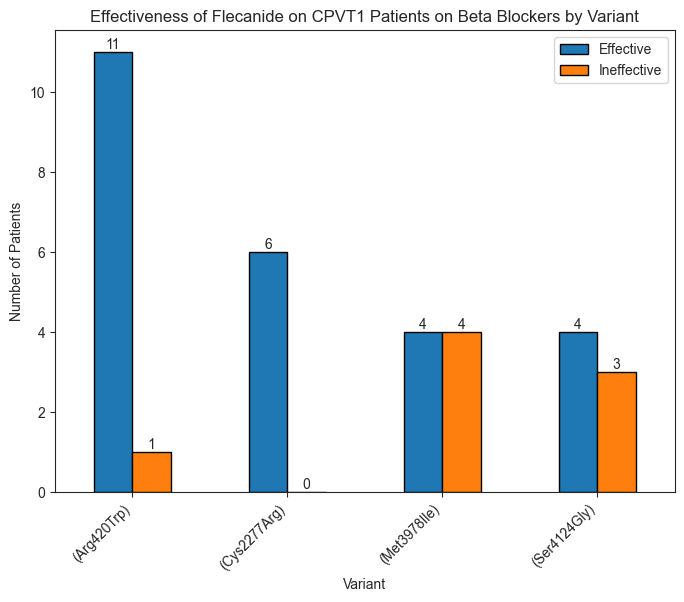

In [37]:
top_flecainide.drop(
    columns="Total"
).plot(
    x="p_posedit_str", kind="bar", figsize=(8, 6), edgecolor="black"
)

plt.xticks(rotation=45, ha="right")
plt.title(
    "Effectiveness of Flecanide on CPVT1 Patients on Beta Blockers by Variant")

plt.xlabel("Variant")
plt.ylabel("Number of Patients")

add_bar_labels(plt.gca(), ignore_zero=False)
save_current_plot("flecainide_effectiveness")

plt.show()

In [38]:
def get_total_patients_in_treatment(
        treatment_name: str, engine, max_num_variants=10):
    stmt = text("""
    SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    JOIN individual_variant iv
    ON tr.patient_id = iv.individual_id
    JOIN variant v
    ON iv.variant_id = v.variant_id
    JOIN sequence_variant sv
    ON sv.sequence_variant_id = v.sequence_variant_id
    WHERE 1 = 1 
    AND tr.patient_id IN (
    -- ONLY CPVT1 patients
        SELECT individual_id
        FROM cpvt_patients_v
    ) 
    AND tr.patient_id IN (
    -- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
        SELECT tr.patient_id
        FROM treatment_record tr
        JOIN treatment t
        ON tr.treatment_id = t.treatment_id
        WHERE t.treatment_name = 'Beta blocker'
        AND tr.treatment_taken = TRUE
    )
    AND tr.treatment_taken = TRUE
    AND t.treatment_name = :treatment_name
    AND sv.p_posedit_str IS NOT NULL
    GROUP BY sv.p_posedit_str, treatment_name
    ORDER BY num_patients DESC
    LIMIT :max_num_variants
    """)
    stmt = stmt.bindparams(treatment_name=treatment_name,
                           max_num_variants=max_num_variants)

    df = pd.read_sql(stmt, engine)

    return df


total_flec = get_total_patients_in_treatment("Flecainide", engine)
total_flec

,p_posedit_str,treatment_name,num_patients
0,(Arg420Trp),Flecainide,12
1,(Met3978Ile),Flecainide,9
2,(Ser4124Gly),Flecainide,7
3,(Cys2277Arg),Flecainide,6
4,(Glu1724Lys),Flecainide,4
5,(Val4771Ile),Flecainide,4
6,(Glu4187Gln),Flecainide,4
7,(Ile4587Val),Flecainide,3
8,(Asp3638Ala),Flecainide,3
9,(Arg407Ser),Flecainide,3


In [39]:
sns.set_style("ticks")

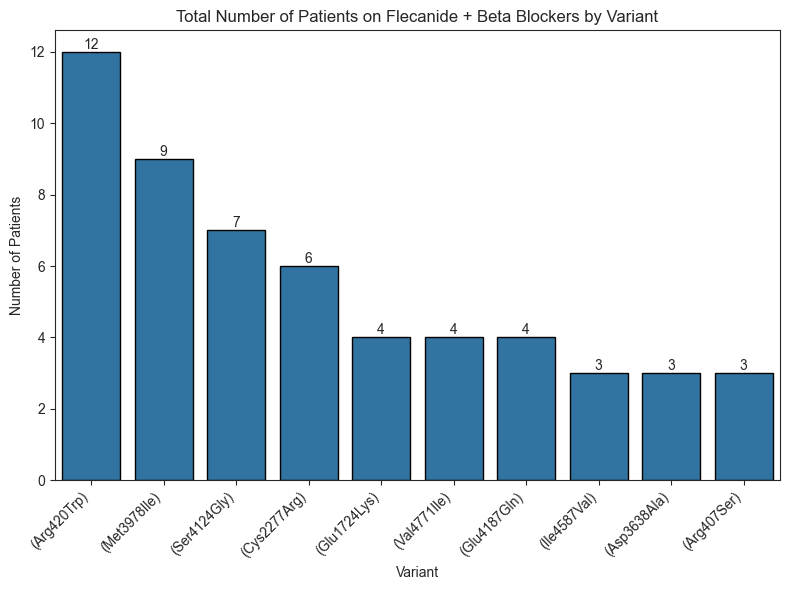

In [40]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=total_flec, x="p_posedit_str", y="num_patients",
                 edgecolor="black")

add_bar_labels(ax)

plt.xticks(rotation=45, ha="right")
plt.title("Total Number of Patients on Flecanide + Beta Blockers by Variant")
plt.xlabel("Variant")
plt.ylabel("Number of Patients")

plt.tight_layout()

save_current_plot("total_flecainide")

plt.show()


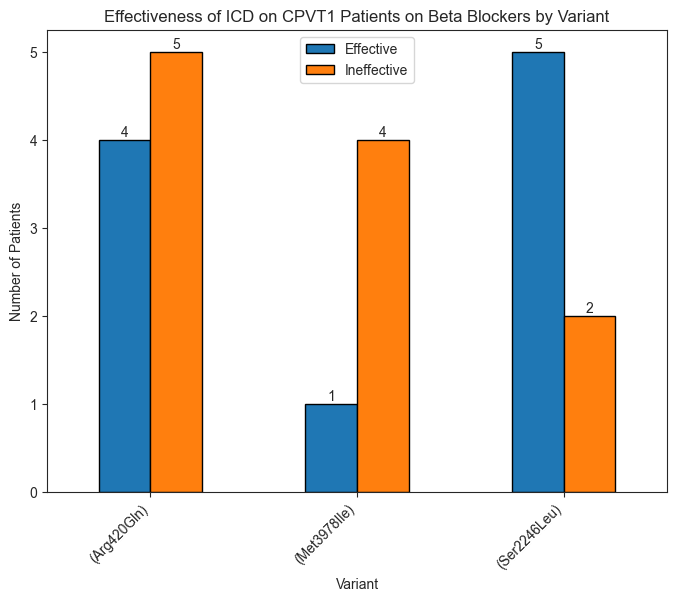

In [41]:
top_icd = get_num_effective_treatment("Implantable cardioverter-defibrillator", engine)

top_icd.drop(columns="Total").plot(
    x="p_posedit_str", kind="bar", figsize=(8, 6), edgecolor="black"
)

add_bar_labels(plt.gca(), ignore_zero=False)

plt.xticks(rotation=45, ha="right")
plt.title("Effectiveness of ICD on CPVT1 Patients on Beta Blockers by Variant")

plt.xlabel("Variant")
plt.ylabel("Number of Patients")

save_current_plot("icd_effectiveness")

plt.show()

In [42]:
top_icd.to_csv(
    os.path.join(figures_dir, "icd_effectiveness.csv"), index=False)

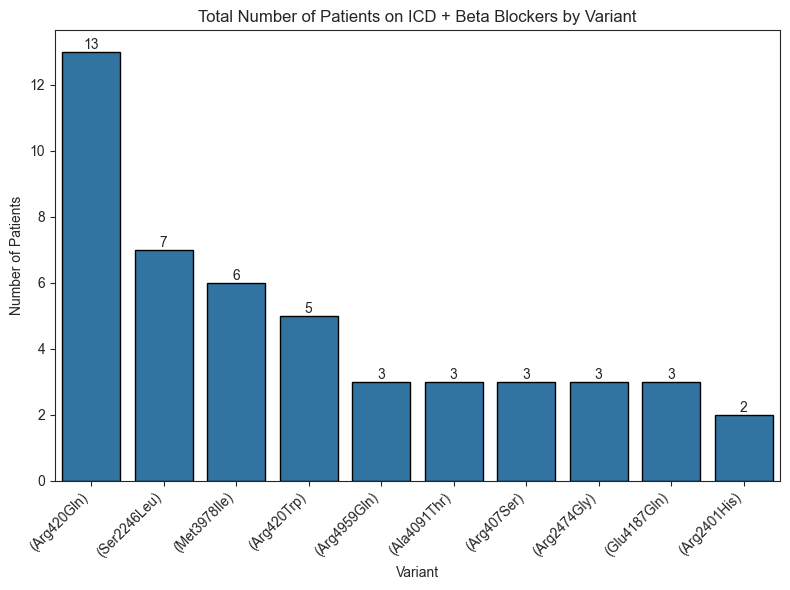

In [43]:
total_icd = get_total_patients_in_treatment(
    "Implantable cardioverter-defibrillator", engine)

plt.figure(figsize=(8, 6))

ax = sns.barplot(data=total_icd, x="p_posedit_str", y="num_patients",
                 edgecolor="black")
add_bar_labels(ax)

plt.xticks(rotation=45, ha="right")
plt.title("Total Number of Patients on ICD + Beta Blockers by Variant")
plt.xlabel("Variant")
plt.ylabel("Number of Patients")

plt.tight_layout()

save_current_plot("total_icd")
plt.show()

In [63]:
from sqlalchemy import Engine


def make_stmt_fisher(treatment: str, num_top_variants: int):
    stmt = text("""
SELECT sv.p_posedit_str, treatment_name, COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE 1 = 1 
AND tr.patient_id IN (
-- ONLY CPVT1 patients
    SELECT individual_id
    FROM cpvt_patients_v
) 
AND tr.patient_id IN (
-- ONLY PATIENTS WHO ARE TAKING BETA BLOCKERS
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name = 'Beta blocker'
    AND tr.treatment_taken = TRUE
)
AND tr.patient_id IN (
-- ONLY take patients with the top 5 variants by number of individuals
    SELECT iv.individual_id
    FROM individual_variant iv
    WHERE v.variant_id IN (
        SELECT v2.variant_id 
        FROM variant_num_individuals_v v2 
        ORDER BY v2.num_individuals DESC 
        LIMIT :num_top_variants
    )
)
AND tr.treatment_taken = TRUE
-- only treatments that are treatment of intereest and beta blockers
AND t.treatment_name IN (:treatment_name, 'Beta blocker')
GROUP BY sv.p_posedit_str, treatment_name
ORDER BY sv.p_posedit_str, treatment_name
                           """)
    stmt = stmt.bindparams(
        treatment_name=treatment,
        num_top_variants=num_top_variants)

    print(
        f"Creating Fisher table with comparing the proportion of patients taking {treatment} + beta blockers to beta blockers only")

    """AND tr.patient_id NOT IN (
-- Exclude patients taking any other treatment than the one specified + beta blockers
    SELECT tr.patient_id
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE t.treatment_name NOT IN (:treatment_name, 'Beta blocker')
    AND tr.treatment_taken = TRUE
)"""

    return stmt


def create_fisher_table(
        treatment: str,
        num_top_variants: int,
        eng: Engine,
        short_treatment: str = None
):
    df_fisher = pd.read_sql(make_stmt_fisher(treatment, num_top_variants), eng)

    treatment_name = treatment if short_treatment is None else short_treatment

    df_fisher["treatment_name"] = df_fisher["treatment_name"].apply(
        lambda
            x: "Total" if x == "Beta blocker" else f"{treatment_name}_and_beta_blocker")
    df_fisher = df_fisher.pivot(
        index="p_posedit_str", columns="treatment_name",
        values="num_patients").fillna(0)
    df_fisher["beta_blocker_only"] = (df_fisher["Total"] -
                                      df_fisher[
                                          f"{treatment_name}_and_beta_blocker"])

    # rearrange
    df_fisher = df_fisher[
        [f"{treatment_name}_and_beta_blocker", "beta_blocker_only", "Total"]]

    df_fisher = df_fisher.astype(int)
    df_fisher.reset_index(inplace=True)
    # drop treatment name
    df_fisher.columns.name = None
    return df_fisher


fisher_flecainide = create_fisher_table("Flecainide", 5, engine)
fisher_flecainide

,p_posedit_str,Flecainide_and_beta_blocker,beta_blocker_only,Total
0,(Arg420Gln),2,22,24
1,(Arg420Trp),12,5,17
2,(Gly357Ser),0,94,94
3,(Ser2246Leu),3,6,9
4,Gly2337Val,0,21,21


In [64]:
fisher_flecainide.to_csv(
    os.path.join(figures_dir, "flecainide_fisher.csv"), index=False)


In [65]:
fisher_icd = create_fisher_table("Implantable cardioverter-defibrillator", 5,
                                 engine, short_treatment="ICD")
fisher_icd

,p_posedit_str,ICD_and_beta_blocker,beta_blocker_only,Total
0,(Arg420Gln),13,11,24
1,(Arg420Trp),5,12,17
2,(Gly357Ser),1,93,94
3,(Ser2246Leu),7,2,9
4,Gly2337Val,1,20,21


In [66]:
fisher_icd.to_csv(
    os.path.join(figures_dir, "icd_fisher.csv"), index=False)

In [48]:
beta_blocker_eff = pd.read_sql("""
SELECT sv.p_posedit_str, 
    tr.effective AS Beta_Blocker_Effective,
    COUNT(tr.patient_id) AS num_patients
FROM treatment_record tr
JOIN treatment t
ON tr.treatment_id = t.treatment_id
JOIN individual_variant iv
ON tr.patient_id = iv.individual_id
JOIN variant v
ON iv.variant_id = v.variant_id
JOIN sequence_variant sv
ON sv.sequence_variant_id = v.sequence_variant_id
WHERE tr.patient_id IN (
    SELECT individual_id
    FROM cpvt_patients_v
)
AND sv.p_posedit_str IN (
-- Only include variants where there will be at least 5 patients TOTAL (effective and ineffective)
    SELECT sv2.p_posedit_str
    FROM treatment_record tr2
    JOIN treatment t2
    ON tr2.treatment_id = t2.treatment_id
    JOIN individual_variant iv2
    ON tr2.patient_id = iv2.individual_id
    JOIN variant v2
    ON iv2.variant_id = v2.variant_id
    JOIN sequence_variant sv2
    ON sv2.sequence_variant_id = v2.sequence_variant_id
    WHERE tr2.patient_id IN (
        SELECT individual_id
        FROM cpvt_patients_v
    )
    AND tr2.treatment_taken = TRUE
    AND t2.treatment_name = 'Beta blocker'
    AND tr2.effective IS NOT NULL
    GROUP BY sv2.p_posedit_str
    HAVING COUNT(tr2.patient_id) >= 5
)
AND tr.treatment_taken = TRUE
AND t.treatment_name = 'Beta blocker'
AND tr.effective IS NOT NULL
GROUP BY sv.p_posedit_str, tr.effective
ORDER BY sv.p_posedit_str, tr.effective
""", engine)
beta_blocker_eff

,p_posedit_str,beta_blocker_effective,num_patients
0,(Arg2401His),False,4
1,(Arg2401His),True,2
2,(Arg420Gln),False,8
3,(Arg420Gln),True,10
4,(Arg420Trp),False,12
5,(Arg420Trp),True,5
6,(Cys2277Arg),False,6
7,(Cys2277Arg),True,2
8,(Glu1724Lys),False,3
9,(Glu1724Lys),True,2


In [49]:
bb_percents = beta_blocker_eff.pivot(
    index="p_posedit_str", columns="beta_blocker_effective",
    values="num_patients").fillna(0)
# bb_percents["% Effective"] = (100 * bb_percents["True"]) / (bb_percents["True"] + bb_percents["False"])
bb_percents.astype(int)
bb_percents["% Effective"] = 100 * bb_percents[True] / (
        bb_percents[True] + bb_percents[False])
bb_percents.reset_index(inplace=True)
bb_percents.columns.name = None
bb_percents.sort_values("% Effective", ascending=False, inplace=True)
bb_percents

,p_posedit_str,False,True,% Effective
9,Gly2337Val,1.0,10.0,90.909091
1,(Arg420Gln),8.0,10.0,55.555556
6,(Met3978Ile),7.0,7.0,50.000000
5,(Gly3946Ser),3.0,3.0,50.000000
4,(Glu1724Lys),3.0,2.0,40.000000
7,(Ser2246Leu),5.0,3.0,37.500000
0,(Arg2401His),4.0,2.0,33.333333
2,(Arg420Trp),12.0,5.0,29.411765
3,(Cys2277Arg),6.0,2.0,25.000000
8,(Ser4124Gly),6.0,0.0,0.000000


In [50]:
# export the data
bb_percents.to_csv(
    os.path.join(figures_dir, "beta_blocker_effectiveness.csv"), index=False)


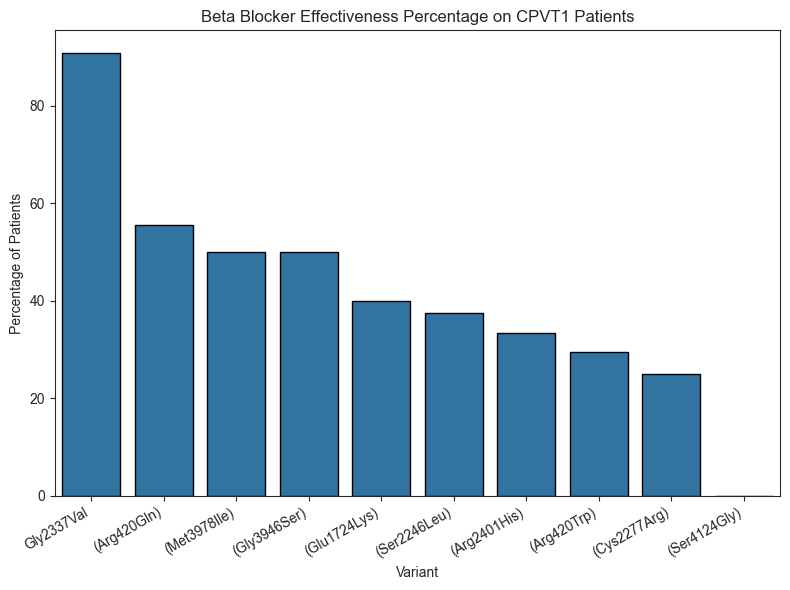

In [51]:
plt.figure(figsize=(8, 6))

# order by the percentage of patients that are effective
ax = sns.barplot(data=bb_percents, x="p_posedit_str", y="% Effective",
                 edgecolor="black")

plt.xticks(rotation=30, ha="right")
plt.xlabel("Variant")
plt.ylabel("Percentage of Patients")
plt.title("Beta Blocker Effectiveness Percentage on CPVT1 Patients")

plt.tight_layout()

save_current_plot("beta_blocker_effectiveness_pcy")

plt.show()

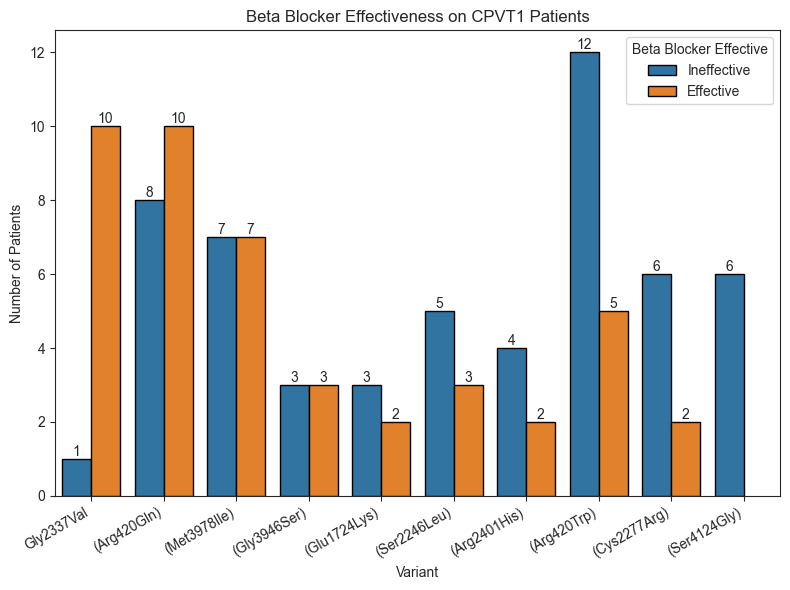

In [52]:
plt.figure(figsize=(8, 6))

beta_blocker_eff_plt = beta_blocker_eff.copy()
beta_blocker_eff_plt["beta_blocker_effective"] = beta_blocker_eff_plt["beta_blocker_effective"].apply(
    lambda x: "Effective" if x else "Ineffective")

# order by the percentage of patients that are effective
ax = sns.barplot(data=beta_blocker_eff_plt, x="p_posedit_str", y="num_patients",
                 hue="beta_blocker_effective", edgecolor="black",
                 order=bb_percents["p_posedit_str"])

plt.xticks(rotation=30, ha="right")
plt.xlabel("Variant")
plt.ylabel("Number of Patients")
plt.title("Beta Blocker Effectiveness on CPVT1 Patients")

plt.legend(title="Beta Blocker Effective", )

add_bar_labels(ax)
plt.tight_layout()

save_current_plot("beta_blocker_effectiveness_values")

plt.show()
